In [1]:
import numpy as np
import jax.numpy as jnp
from pathlib import Path
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# figure aesthetics
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])  # for dark themes
# plt.style.use(["../utils/notebook.mplstyle"])  # for light theme

cdata, cslow, cfast = 'C0', 'C1', 'C2'

In [3]:
# custom libraries
import sys, os

sys.path.append(os.path.abspath('../../spaths'))
import spaths

sys.path.append(os.path.abspath('..'))
from utils.mpl_utils import coord_grid

In [847]:
lam = 1e-3
fun = 1e+0
gam = 1e-3# * 5.6
sig = 5.5

eps = 1e-2

In [848]:
def drif(t, x, dx):
    y1, y2, z = x
    
    dx[0] = lam*y1 - fun*y2 - gam*y1*z
    dx[1] = fun*y1 + lam*y2 - gam*y2*z
    dx[2] = (y1**2 + y2**2 - z) / eps

def disp(t, x, dx):
    dx[0,0] = sig
    dx[1,1] = sig
    dx[2,2] = sig / np.sqrt(eps)

sde = spaths.ItoSDE(drif, disp, noise_mixing_dim=3)

In [849]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [850]:
# simulation params
dt = .3 * eps
x0 = 0.0, 0.0, 0.0
tspan = (0.0, 100.0)

In [851]:
ens0 = np.array([x0])
ens0.shape

(1, 3)

In [852]:
sol = em.solve(sde, ens0, tspan, dt)

In [853]:
times = sol.t
path = sol.p[0]

In [854]:
path.shape

(33335, 3)

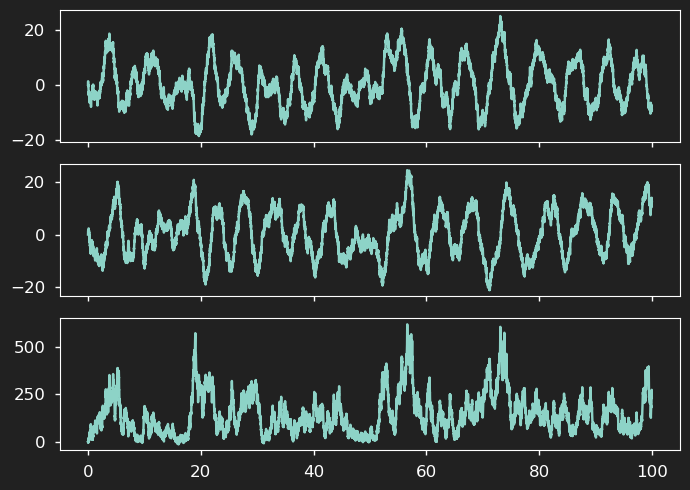

In [855]:
fig, axs = plt.subplots(nrows=len(path.T), sharex=True)
for p, ax in zip(path.T, axs):
    ax.plot(times, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

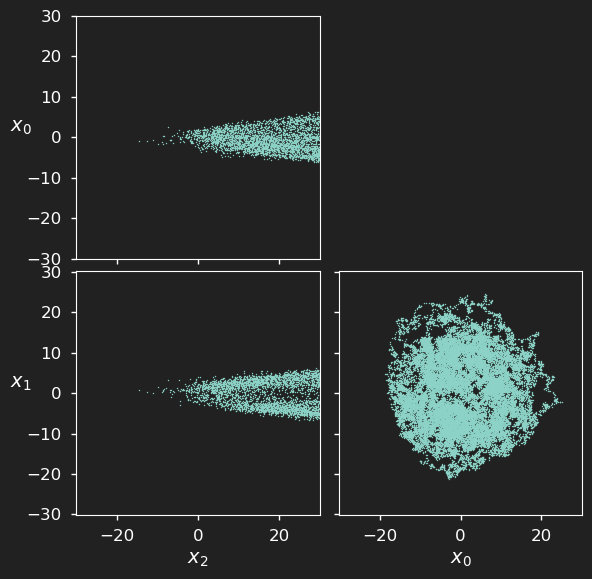

In [862]:
fig = plt.figure(figsize=(10,10))

gs = coord_grid(fig, path, xylim=[-30.1, 30.1])

plt.show(fig)
plt.close(fig)

In [857]:
y1, y2, z = path.T

In [858]:
r = np.sqrt(y1**2 + y2**2)

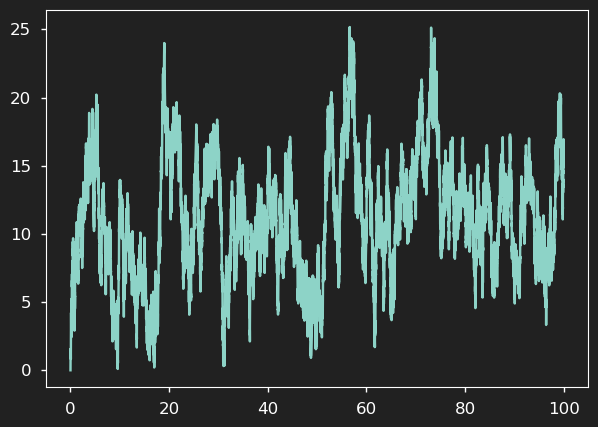

In [859]:
plt.plot(times, r);

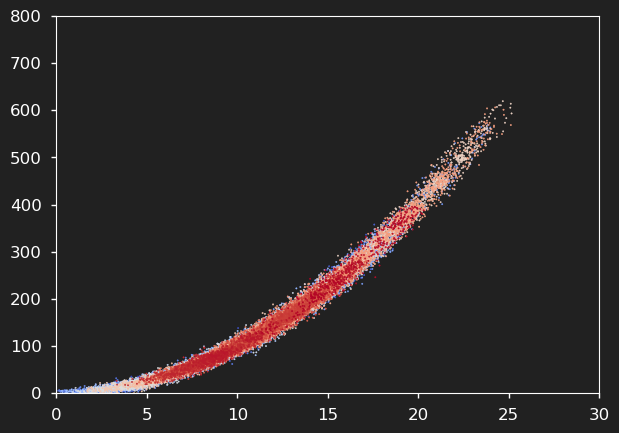

In [861]:
plt.scatter(r, z, s=1, c=times)
plt.xlim([0, 30])
plt.ylim([0,800])

plt.show()

## Time-scale separation

In [807]:
data = path[::10]
data.shape

(3334, 3)

In [808]:
# local noise covaraiances of sde at the data points
ln_covs = dmaps.lnc_ito(data, sde)

In [809]:
e_vals, e_vecs = zip(*[np.linalg.eigh(cov) for cov in ln_covs])  # zip(*) for transposing
e_vals, e_vecs = np.array(e_vals), np.array(e_vecs)

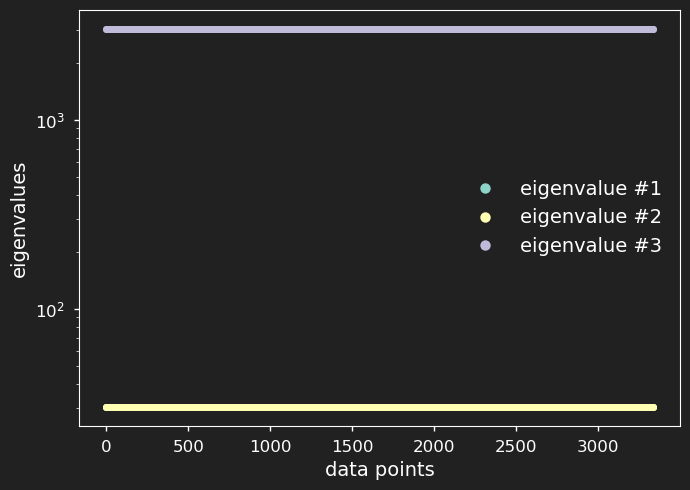

In [810]:
fig, ax = plt.subplots()
for n, e_val, in enumerate(e_vals.T):
    ax.plot(e_val, 'o', label=f"eigenvalue #{n+1}", c=f'C{n}', ms=5)
ax.legend()
ax.set_yscale('log')

ax.set_xlabel('data points')
ax.set_ylabel('eigenvalues')

fig.tight_layout()
plt.show(fig)
plt.close(fig)